In [1]:
import os, os.path
import sys
import codecs
import logging as log
from time import time
import pickle
import io
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from sklearn.externals import joblib
import sklearn
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import nltk
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.text import Text
from itertools import *

C:\Users\kec52\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#stop word from txt files to lists
with open ('C:/Users/kec52/Documents/BLtext_research/latin_stop.txt', 'r') as latin:
    latin_stop = [word.strip(",.") for line in latin for word in line.lower().split()]
    latin_stop.append('ab')

with open ('C:/Users/kec52/Documents/BLtext_research/german_stop.txt', 'r') as german:
    german_stop = [word.strip(",.") for line in german for word in line.lower().split()]
    german_stop.append('aber')
    
with open ('C:/Users/kec52/Documents/BLtext_research/french_stop.txt', 'r') as french:
    french_stop = [word.strip(",.") for line in french for word in line.lower().split()]
    french_stop.append('alors')
    
with open ('C:/Users/kec52/Documents/BLtext_research/spanish_stop.txt', 'r') as spanish:
    spanish_stop = [word.strip(",.") for line in spanish for word in line.lower().split()]
    spanish_stop.append('un')
    
with open ('C:/Users/kec52/Documents/BLtext_research/extrastop.txt', 'r') as extra: #covers spelling mistakes
    extrastop = [word.strip(",.") for line in extra for word in line.lower().split()]
    extrastop.append('fhall')

english_stop = list(STOPWORDS)

extra_stop = ['tli', 'https', 'thk', 'http', 'org','ofthe', 'tha', 'tho', 'ther', 'there', 'der', 'dat', 'ain', 'tis', 'thee', 'thou', 'thy', 'waa']
stop_words = english_stop + extra_stop + spanish_stop + german_stop + latin_stop + french_stop



In [3]:
def save_corpus( out_prefix, X, terms, doc_ids ):
    matrix_outpath = "%s.pkl" % out_prefix 
    log.info( "Saving document-term matrix to %s" % matrix_outpath )
    joblib.dump((X,terms,doc_ids), matrix_outpath ) 

In [4]:
def load_corpus( in_path ):
    (X,terms,doc_ids) = joblib.load( in_path )
    return (X, terms, doc_ids)

In [5]:
def tokenize(text):
    x = [token for token in simple_preprocess(text) if token not in stop_words and len(token) > 2]
    print(x[:10])
    return x

In [6]:
#lemmatize for verbs
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        lemma = word
    return lemma

#lemmatize for nouns
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [7]:
#clean texts
def clean_txt(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 2]
    tokens = [get_lemma(token) for token in tokens]
    tokens = [get_lemma2(token) for token in tokens]
    tokens = " ".join(str(x) for x in tokens)
    return tokens

In [8]:
class File2Doc(object):
    def __init__(self, top_dir):
        self.top_dir = top_dir

    def __iter__(self):
        for root, dirs, files in os.walk(self.top_dir):
            for fname in filter(lambda fname: fname.endswith('.txt'), files):
                with open(os.path.join(root, fname), encoding='utf8', errors='ignore') as file:
                    document = file.read()
                    #x = clean_txt(document) # or whatever tokenization suits
                    yield document

In [9]:
class MyDocIterator(object):
    '''expects a path of folders in list'''
    def __init__(self, folders=None):
        self.folders = folders
        if self.folders is not None:
            assert isinstance(self.folders, list), 'folders should be a list'
        if self.folders is None:
            raise TypeError('Please specify at least one folder')
    
    def __iter__(self):
        k = []
        if self.folders is not None:
            f = [File2Doc(folder) for folder in self.folders]
            k.extend(f)
        return chain.from_iterable(k)

In [10]:
def get_paths(corpus_path):
    return sorted([os.path.join(corpus_path, fn) for fn in os.listdir(corpus_path)])

In [11]:
def get_tfidf(my_docs):
    #tfidf_vectorizer = text.TfidfVectorizer(input='filename', analyzer='word', encoding='utf-8',tokenizer=tokenize, stop_words = STOPWORDS, min_df=5, max_df = 0.85)
    tfidf_vectorizer = text.TfidfVectorizer(preprocessor = clean_txt, tokenizer=tokenize)
    dtm = tfidf_vectorizer.fit_transform(my_docs).toarray()
    print('dtm size: ', dtm.shape)
    tfidf_topic_vocab = np.array(tfidf_vectorizer.get_feature_names() )
    print('length topic vocab: ', len(tfidf_topic_vocab))
    return dtm, tfidf_topic_vocab

In [12]:
def get_NMF_topics(dtm, vocab, corpus_name, num_topics, num_words):
    clf = NMF(n_components=num_topics, random_state=1)
    print(clf)
    doc_topic = clf.fit_transform(dtm)
    word_dict={}
    for topic_idx, topic in enumerate (clf.components_):
        print ("Topic ", topic_idx)
        print (" ".join([vocab[i] for i in topic.argsort()[:-num_words - 1:-1]]))
        word_dict['Topic # ' + '{:02d}'.format(topic_idx +1)] = [ vocab[i] for i in topic.argsort()[:-num_words - 1:-1]]
    topics = pd.DataFrame(word_dict)
    topics.to_csv(corpus_name+'_topics.csv')
    doc_topic = doc_topic / np.sum(doc_topic, axis=0, keepdims=True)
    return doc_topic

In [13]:
def doc_names_topics(filenames, doc_topic, num_topics):
    documents = []
    for fn in filenames:
        basename = os.path.basename(fn)
        name, ext = os.path.splitext(basename)
        name = name.rstrip('0123456789')
        documents.append(name)
    doc_names = np.asarray(documents)
    doc_topic_orig = doc_topic.copy()
    num_groups = len(set(doc_names))
    doc_topic_grouped = np.zeros((num_groups, num_topics))
    print('num groups: ',num_groups)
    documents = sorted(set(doc_names))
    return doc_topic_orig, doc_topic_grouped, documents

def top_topics_total(doc_topic,documents, num_to_display):
    top_topics_total = []
    print('doc_topic len is: ', len(doc_topic))
    for i in range(len(doc_topic)):
        top_topics = np.argsort(doc_topic[i,:])[::-1][0:num_to_display]
        top_topics_str = ' '.join(str(topic) for topic in top_topics)
        print("{}: {}".format(documents[i], top_topics_str))
        top_topics_split = top_topics_str.split(' ')
        top_topics_total.extend(top_topics_split)
    return top_topics_total

def NMF_vis(top_topics_total):
    #make a giant array of top topics for all the documents
    counts = Counter(top_topics_total)
    labels, values = zip(*counts.items())
    indSort = np.argsort(values)[::-1]
    # rearrange 
    labels = np.array(labels)[indSort]
    values = np.array(values)[indSort]
    indexes = np.arange(len(labels))
    bar_width = 0.3
    plt.bar(indexes, values)
    # add labels
    plt.xticks(indexes + bar_width, labels)
    plt.show()
    

In [14]:
pro_files = get_paths('C:/Users/kec52/Documents/BLtext_research/proVaxTextLib/proTexts')

pro_dtm, pro_word = get_tfidf(pro_files)

In [15]:
my_pro_docs = MyDocIterator(['C:/Users/kec52/Documents/BLtext_research/proVaxTextLib/proTexts'])

In [16]:
pro_dtm, pro_word = get_tfidf(my_pro_docs)

['rowland', 'oliver', 'price', 'boards', 'goskelt', 'printer', 'little', 'queen', 'sueâ', 'rowland']
['rowland', 'oliver', 'price', 'board', 'goskelt', 'printer', 'little', 'queen', 'sueâ', 'rowland']
['uxv', 'royal', 'college', 'phyficians', 'london', 'vaccination', 'containing', 'opinions', 'royal', 'colleges']
['uxv', 'royal', 'college', 'phyficians', 'london', 'vaccination', 'contain', 'opinion', 'royal', 'college']
['report', 'state', 'progress', 'vaccination', 'bengal', 'years', 'submitted', 'medical', 'board', 'fort']
['report', 'state', 'progress', 'vaccination', 'bengal', 'year', 'submit', 'medical', 'board', 'fort']
['digitized', 'internet', 'archive', 'archive', 'details', 'king', 'college', 'london', 'library', 'fto']
['digitize', 'internet', 'archive', 'archive', 'king', 'college', 'london', 'library', 'fto', 'comi']
['digitized', 'tine', 'internet', 'arcliive', 'littps', 'arcliive', 'details', 'report', 'surgeons', 'edinburgh']
['digitize', 'tine', 'internet', 'arcliive',

In [17]:
pro_topics = get_NMF_topics(pro_dtm, pro_word,'pro_corpus', 4, 20)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=4, random_state=1, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)
Topic  0
pox small vaccination vaccinate case child disease year cent person attack sheffield time death medical hospital lymph know fact state
Topic  1
pox college small vaccination inoculation fmall birch cafe report royal phyficians practice vaccine general cow inoculate native surgeon difeafe court
Topic  2
vaccine pock smallpox cow disease pox year vaccination vesicle small day case puncture lymph inoculation matter arm pustule heim subject
Topic  3
conscience starch vaccination jenner doctor mother fortune spook robb gruel exit biscuit child worse prophet objector sauce verily declare babe


In [18]:
pro_topic_orig, pro_topic_grouped, pro_docs = doc_names_topics(pro_files, pro_topics, 6)

num groups:  16


In [19]:
top_topics = top_topics_total(pro_topic_orig,pro_docs, 3)

doc_topic len is:  16
1807, A Rowland for an Olivier: 1 2 0
1807, Report of the Royal College of Physicians of London: 1 3 2
1807, Report on the state and progress of vaccination in Bengal: 1 3 2
1808, Hints for the consideration of Parliament: 1 0 2
1809, Report of the surgeons of the Edinburgh Vaccine Institution: 2 1 3
1828, Observations on cowpox: 2 3 0
1829, The question of vaccination popularly considered: 2 0 3
1830, A cottage dialogue on vaccination: 0 1 3
1839, Vaccination and re-vaccination: 2 0 3
1857, On the protective and modifying powers of vaccination: 0 2 1
1859, Vaccination: 0 3 2
1869, Compulsory vaccination: 0 2 3
1869, Is vaccination injurious: 0 2 3
1888, A pamphlet on vaccination: 0 3 2
1889, Report on an epidemic of small-pox at Sheffield: 0 3 2
1899, Vaccination Burke'd: 3 2 1


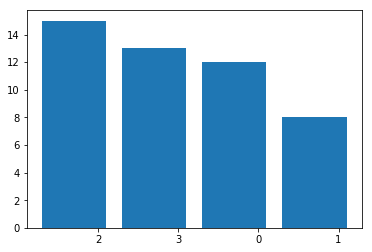

In [20]:
NMF_vis(top_topics)

In [21]:
anti_files = get_paths('C:/Users/kec52/Documents/BLtext_research/antiVaxTextLib/antiTexts')

In [22]:
my_anti_docs = MyDocIterator(['C:/Users/kec52/Documents/BLtext_research/antiVaxTextLib/antiTexts'])

In [23]:
anti_dtm, anti_word= get_tfidf(my_anti_docs)

['ros', 'puli', 'copy', 'jnswer', 'queries', 'hontiott', 'college', 'burgeons', 'letter', 'college']
['pul', 'copy', 'jnswer', 'query', 'hontiott', 'college', 'burgeon', 'letter', 'college', 'physician']
['digitized', 'internet', 'archive', 'archive', 'details', 'king', 'college', 'london', 'inquiry', 'anttvariolous']
['digitize', 'internet', 'archive', 'archive', 'king', 'college', 'london', 'inquiry', 'anttvariolous', 'power']
['yeaes', 'experience', 'public', 'vaccinator', 'small', 'pox', 'vaccination', 'lictntittie', 'ihe', 'royal']
['yeaes', 'experience', 'public', 'vaccinator', 'small', 'pox', 'vaccination', 'lictntittie', 'ihe', 'royal']
['vaccination', 'remonstrance', 'respecting', 'vaccination', 'addressed', 'hon', 'henry', 'bruce', 'vice', 'president']
['vaccination', 'remonstrance', 'respect', 'vaccination', 'address', 'hon', 'henry', 'bruce', 'vice', 'president']
['haye', 'yaccinated', 'peotection', 'small', 'pox', 'vaccinated', 'peotection', 'small', 'pox', 'essay']
['haye

In [24]:
anti_topics = get_NMF_topics(anti_dtm, anti_word, 'anti_corpus', 6, 20)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=6, random_state=1, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)
Topic  0
pox small disease case vaccination cow practice inoculation vesicle child day vaccine time appearance year eruption areola pustule produce jenner
Topic  1
smallpox vaccination cowpox jenner vaccinate year case disease medical child time horsegrease death practice day inoculation london tion person health
Topic  2
child infect syphilis vaccinate syphilitic vaccination lymph series chiabrera manzone time case mother month depaul adenitis girolama norcy day vesicle
Topic  3
law vaccination disease medical pox blood parliament small child right compulsory health focus surgeon men vaccinate public legislator force know
Topic  4
vaccination pox small death year disease mortality vaccinate case leicester rate medical report cause increase general table number epidemic time
Topic  5
pox vaccination small vaccinate disease y

In [25]:
anti_topic_orig, anti_topic_grouped, anti_docs = doc_names_topics(anti_files, anti_topics, 6)

num groups:  18


In [26]:
anti_top_topics = top_topics_total(anti_topic_orig,anti_docs, 3)

doc_topic len is:  18
1807_a_copy_of_an_answer_to_the_queries: 0 3 4
1809, An inquiry into the antivariolus practice of vaccination: 0 2 1
1866, Twenty years' experience as a public vaccinator: 5 4 3
1866, Vaccination, a remonstrance: 1 2 4
1868, Have you been vaccinated: 0 5 4
1868, Vaccination and its tested effects: 4 0 5
1870, Compulsory vaccination - report of a public meeting: 4 5 0
1871, An attempt to prove that vaccination with its compulsory law: 3 0 5
1873, Disasters from vaccination: 2 5 4
1874, The political side of the vaccination system: 3 5 4
1876, Vaccination brought home to the people: 3 0 5
1877, Vaccination tracts: 1 2 3
1881, Sanitation, not vaccination: 4 3 0
1884, Compulsory vaccination in England: 4 2 5
1885, The story of a great delusion: 1 0 5
1889, Forty-five years of registration statistics: 4 5 3
1906, Professional opinion adverse to vaccination: 1 3 2
1912, Leicester, Sanitation vs Vaccination: 4 2 1


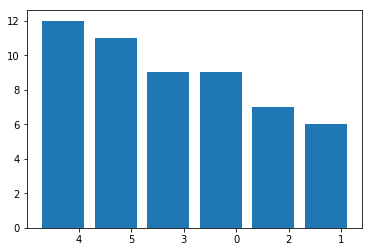

In [27]:
NMF_vis(anti_top_topics)

In [28]:
both_files = get_paths('C:/Users/kec52/Documents/BLtext_research/bothTexts')

In [29]:
my_both_docs = MyDocIterator(['C:/Users/kec52/Documents/BLtext_research/bothTexts'])

In [31]:
both_dtm, both_word= get_tfidf(my_both_docs)

['rowland', 'oliver', 'price', 'boards', 'goskelt', 'printer', 'little', 'queen', 'sueã', 'rowland']
['rowland', 'oliver', 'price', 'board', 'goskelt', 'printer', 'little', 'queen', 'sueã', 'rowland']
['uxv', 'royal', 'college', 'phyficians', 'london', 'vaccination', 'containing', 'opinions', 'royal', 'colleges']
['uxv', 'royal', 'college', 'phyficians', 'london', 'vaccination', 'contain', 'opinion', 'royal', 'college']
['report', 'state', 'progress', 'vaccination', 'bengal', 'years', 'submitted', 'medical', 'board', 'fort']
['report', 'state', 'progress', 'vaccination', 'bengal', 'year', 'submit', 'medical', 'board', 'fort']
['ros', 'puli', 'copy', 'jnswer', 'queries', 'hontiott', 'college', 'burgeons', 'letter', 'college']
['pul', 'copy', 'jnswer', 'query', 'hontiott', 'college', 'burgeon', 'letter', 'college', 'physician']
['digitized', 'internet', 'archive', 'archive', 'details', 'kingâ', 'college', 'london', 'library', 'fto']
['digitize', 'internet', 'archive', 'archive', 'kingâ',

In [32]:
both_topics = get_NMF_topics(both_dtm, both_word, 'both_corpus', 9, 20)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=9, random_state=1, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)
Topic  0
vaccination pox small year vaccinate disease death case mortality cent child medical epidemic person time age hospital fact rate leicester
Topic  1
smallpox vaccination cowpox disease jenner case year medical time vaccinate death horsegrease inoculation practice virus fact person state life child
Topic  2
pox vaccine small vesicle pock day cow disease case year inoculation puncture pustule arm areola matter heim lymph produce vaccination
Topic  3
child syphilis infect syphilitic vaccination vaccinate lymph chiabrera series manzone case depaul time mother month adenitis girolama norcy fact anus
Topic  4
fmall cafe native vaccination pox vaccinate fome calcutta difeafe thefe vaccine fchool boy fame robertfon againft campbell inoculator shoolbred station
Topic  5
law vaccination disease medical pox blood parliament sma

In [33]:
both_topic_orig, both_topic_grouped, both_docs = doc_names_topics(both_files, both_topics, 9)

num groups:  34


In [34]:
both_top_topics = top_topics_total(both_topic_orig,both_docs, 3)

doc_topic len is:  34
1807, A Rowland for an Olivier: 7 5 1
1807, Report of the Royal College of Physicians of London: 4 7 8
1807, Report on the state and progress of vaccination in Bengal: 4 8 7
1807_a_copy_of_an_answer_to_the_queries: 7 8 2
1808, Hints for the consideration of Parliament: 7 8 2
1809, An inquiry into the antivariolus practice of vaccination: 2 7 3
1809, Report of the surgeons of the Edinburgh Vaccine Institution: 2 4 8
1828, Observations on cowpox: 1 2 7
1829, The question of vaccination popularly considered: 2 5 6
1830, A cottage dialogue on vaccination: 8 7 6
1839, Vaccination and re-vaccination: 2 3 0
1857, On the protective and modifying powers of vaccination: 0 7 2
1859, Vaccination: 8 0 3
1866, Twenty years' experience as a public vaccinator: 8 0 6
1866, Vaccination, a remonstrance: 3 1 0
1868, Have you been vaccinated: 7 8 2
1868, Vaccination and its tested effects: 0 7 2
1869, Compulsory vaccination: 3 0 5
1869, Is vaccination injurious: 0 2 5
1870, Compulsory

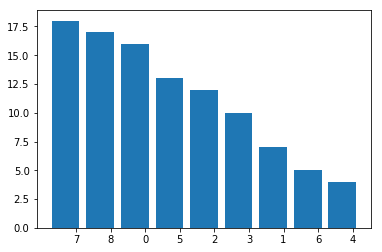

In [35]:
NMF_vis(both_top_topics)